In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8

#symbols = ["Li", "H"]
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
#coordinates = np.array([[0.0,0.0, 0*r_bohr], [0.0, 0.0, 1*r_bohr]])
# Calculation of the Hamiltonian
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")

hf_state = qchem.hf_state(electrons, qubits)
#Calculation of HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def circuit(hf_state, electrons, qubits, H):
    # Prepare the Hartree-Fock state
    print('Updated hf_state is', hf_state)  
    qml.BasisState(hf_state, wires=range(qubits))
    return qml.expval(H)   #Calculating the expectation value of the Hamiltonian

# Commutator calculation for HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
    qml.BasisState(k, wires=range(qubits))
    res = qml.commutator(H, w)   #Calculating the commutator
    return qml.expval(res)

# Commutator calculation for other states except HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
    qml.StatePrep(k, wires=range(qubits))
    res = qml.commutator(H, w) #Calculating the commutator
    return qml.expval(res)

# Energy calculation 
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def ash(params, ash_excitation, hf_state, qubits, H):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
    for i, excitation in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
        elif len(ash_excitation[i]) == 2:
            #print('Single Exc going in is', ash_excitation[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

    return qml.expval(H)  #Calculating the expectation value of the Hamiltonian

# Calculation of New state, same as the above function but with the state return

dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def new_state(hf_state, ash_excitation, params):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
    for i, excitations in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            print('Exc. dealing right now is', ash_excitation[i])
            print('The params that are going in', params[i])
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])

        elif len(ash_excitation[i]) == 2:
            print('Single Exc. dealing right now is', ash_excitation[i])
            print('Single exc params that are going in', params[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

    return qml.state()

def cost(params):
    energy = ash(params, ash_excitation, hf_state, qubits, H)
    return energy

def callback(params):
    print(f"Current parameters: {params}")
    print(f"Current cost: {cost(params)}\n")

def adaptvqe(H, hf_state, electrons, qubits,a_it=1):
    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    optimizer = qml.GradientDescentOptimizer(stepsize=0.5)  #Optimizer
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    #print('Singles are', op1)
    #print('Doubles:', op2)
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]


    for j in range(a_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        # Start with the most recent state (last state in the list)
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state

        for i in operator_pool:
            print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                print('Print, if this is activated - HF state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        print('The current status of ash_excitation is', ash_excitation)
        print('Moving towards parameters')
        params = np.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
        print('The length of parameters is', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = 1e-12, options = {'disp': True, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        #print('The updated state is', ostate)
        # Append the new state to the states list
        states.append(ostate)

    return energies, params




## Function definition - Updated the recycled parameters

In [2]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqesri(adapt_it, e_th):
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                print('Exc. dealing right now is', ash_excitation[i])
                print('The params that are going in', params[i])
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                print('Single Exc. dealing right now is', ash_excitation[i])
                print('Single exc params that are going in', params[i])
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]
    params = np.zeros(len(ash_excitation), requires_grad=True) 
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        # Start with the most recent state (last state in the list)
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                print('Print, if this is activated - HF state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        print('The current status of ash_excitation is', ash_excitation)
        print('Moving towards parameters')
         #Parameters initialization
        params = np.append(params, 0.0)  #Parameters initialization
        print('The length of parameters is', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation




In [ ]:
adaptvqesri(adapt_it=5, e_th=1e-12)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.332568888066893
The adapt iteration now is 0
The current excitation operator is a⁺(0) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(4) is 9.258181025983969e-08
The current excitation operator is a⁺(0) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(6) is 0.0
The current excitation operator is a⁺(1) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(5) is 9.258181027371748e-08
The current excitation operator is a⁺(1) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(7) is 0.0
The current excitation operator is a⁺(2) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(4) is 0.0
The current excitation operator is a⁺(2) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(6) is 1.1698968021417455e-07
The current excitation operator is a⁺(3) a(5)
Print, if this is activated - HF 

/Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The expectation value of a⁺(0) a⁺(1) a(5) a(6) is 0.0
The current excitation operator is a⁺(0) a⁺(1) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(1) a(6) a(7) is 0.28410686098083854
The current excitation operator is a⁺(0) a⁺(2) a(4) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(2) a(4) a(6) is 0.030544625693072067
The current excitation operator is a⁺(0) a⁺(3) a(4) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(5) is 0.0
The current excitation operator is a⁺(0) a⁺(3) a(4) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(7) is 0.3078190525120401
The current excitation operator is a⁺(0) a⁺(3) a(5) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(5) a(6) is 0.277274426818968
The current excitation operator is a⁺(0) a⁺(3) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a

([-1.4300836708403402,
  -1.5694603835520677,
  -1.7436334426149698,
  -1.8421101514362364,
  -1.8504359363275726],
 array([-0.83013641, -1.28923815, -1.01540767, -1.16553372,  0.28114359]),
 [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [1, 5]])

## Powell - 21 Parameters 

In [3]:
adaptvqesri(adapt_it=21, e_th=1e-12)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.332568888066893
The adapt iteration now is 0
The current excitation operator is a⁺(0) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(4) is 9.258181025983969e-08
The current excitation operator is a⁺(0) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(6) is 0.0
The current excitation operator is a⁺(1) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(5) is 9.258181027371748e-08
The current excitation operator is a⁺(1) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(7) is 0.0
The current excitation operator is a⁺(2) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(4) is 0.0
The current excitation operator is a⁺(2) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(6) is 1.1698968021417455e-07
The current excitation operator is a⁺(3) a(5)
Print, if this is activated - HF 

/Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The expectation value of a⁺(0) a⁺(1) a(5) a(6) is 0.0
The current excitation operator is a⁺(0) a⁺(1) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(1) a(6) a(7) is 0.28410686098083854
The current excitation operator is a⁺(0) a⁺(2) a(4) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(2) a(4) a(6) is 0.030544625693072067
The current excitation operator is a⁺(0) a⁺(3) a(4) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(5) is 0.0
The current excitation operator is a⁺(0) a⁺(3) a(4) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(7) is 0.3078190525120401
The current excitation operator is a⁺(0) a⁺(3) a(5) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(5) a(6) is 0.277274426818968
The current excitation operator is a⁺(0) a⁺(3) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a

([-1.4300836708403402,
  -1.5694603835520677,
  -1.7436334426149698,
  -1.8421101514362364,
  -1.8504359363275726,
  -1.8594600250247684,
  -1.8656767410817476,
  -1.8663879748309666,
  -1.884356033007819,
  -1.8844361654314306,
  -1.8844361671921899,
  -1.8844364522332315,
  -1.8844364556758229,
  -1.8844365760316029,
  -1.884436576484849,
  -1.8844612572187276,
  -1.885096631853509,
  -1.885097395511084,
  -1.8850973962695554,
  -1.885123539547584,
  -1.885123539730992],
 array([-1.29108267e+00, -1.00837296e+00, -1.39465612e+00, -7.48122574e-01,
         1.54032144e+00,  1.48424826e+00, -1.42950905e+00,  1.33047435e+00,
        -1.45752777e+00,  1.32872193e+00, -8.66789328e-01, -9.26009670e-01,
         1.60238752e+00,  1.60069689e+00,  6.25660462e+00,  3.26534068e+00,
         6.02638401e-01, -3.33802336e-02, -3.12905473e+00,  1.45033785e-01,
        -4.29568968e-05]),
 [[2, 3, 6, 7],
  [0, 3, 5, 6],
  [0, 1, 4, 5],
  [1, 2, 4, 7],
  [1, 5],
  [2, 6],
  [3, 7],
  [2, 3, 6, 7],
  [0,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


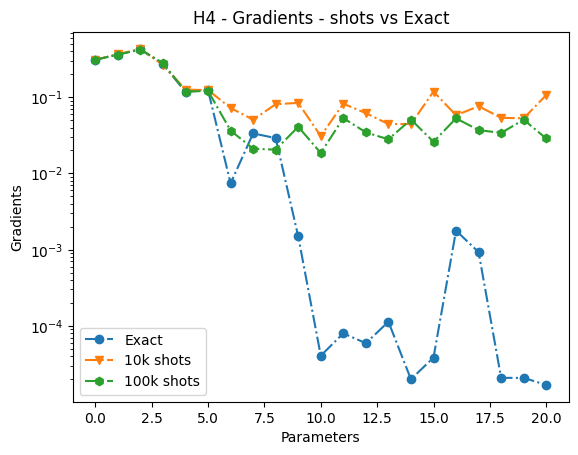

In [8]:
import numpy as np
params = []
for k in range(21):
    params.append(k)

print(params)

G_Exact = np.array([0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
              0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
               5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
                 2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05])

G_100k = np.array([0.31012233368556263, 0.36278153764485294, 0.4224954854006534 , 0.28153706300448905, 0.11874528439791214, 0.12091574177009903,
                  0.036496747329089814, 0.021113196148753528, 0.020510792058557496, 0.04093571514178557, 0.01856540574468836, 0.053177591263377365,
                  0.03457620605522451, 0.02801950135618726, 0.050944905880169374, 0.02601220513310512 , 0.05287811195945368, 0.03704241195091213,
                  0.03403801969187872, 0.0506735825987322, 0.028745987022101658])  #Powell - 100k shots - 0th iteration

G_10k = np.array([0.3099162431306309, 0.36686751091589886 , 0.4303872599459001, 0.26664492219594843,0.12542908670332384, 0.1243034054423584,
                  0.07227267823768933, 0.050733283680761736, 0.08093960390932564, 0.08428620993570457, 0.030903952492093528, 0.0822684282601312,
                  0.061834972747899175, 0.04443504550103138, 0.04451098756987766, 0.11852872186034469, 0.05802126112805322, 0.07620382263558934,
                  0.05366141510645424, 0.052880135251468355,  0.106829094059067]) #Powell - 10k shots - 0th iteration

import matplotlib.pyplot as plt
plt.plot(params, G_Exact, '-.o', label = 'Exact')
plt.plot(params, G_10k, '-.v', label = '10k shots')
plt.plot(params, G_100k, '-.h', label = '100k shots')
plt.legend()
plt.yscale('log')
plt.xlabel('Parameters')
plt.title('H4 - Gradients - shots vs Exact')
plt.ylabel('Gradients')
plt.show()